In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

## Pix2Pix GAN 

In [2]:
# Pix2Pix generator network
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, res_blocks=5):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Pix2Pix discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.norm2 = nn.InstanceNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.norm3 = nn.InstanceNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)
        self.norm4 = nn.InstanceNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = nn.LeakyReLU(0.2, inplace=True)(self.conv1(x))
        x = nn.LeakyReLU(0.2, inplace=True)(self.norm2(self.conv2(x)))
        x = nn.LeakyReLU(0.2, inplace=True)(self.norm3(self.conv3(x)))
        x = nn.LeakyReLU(0.2, inplace=True)(self.norm4(self.conv4(x)))
        x = nn.Sigmoid()(self.conv5(x))
        return x.squeeze()


## Importing and Preprocessing Data

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

normal_dataset = ImageFolder('/kaggle/input/datagan6/Data/Base', transform=transform)
art_dataset = ImageFolder('/kaggle/input/datagan6/Data/Style', transform=transform)

normal_loader = DataLoader(normal_dataset, batch_size=1, shuffle=True)
art_loader = DataLoader(art_dataset, batch_size=1, shuffle=True)


In [7]:
# Checking normal images
normal_sizes = [img.size() for img, _ in normal_loader.dataset]
normal_unique_sizes = set(normal_sizes)
print("Unique image sizes in normal dataset:", normal_unique_sizes)

normal_channels = [img.size(0) for img, _ in normal_loader.dataset]
normal_unique_channels = set(normal_channels)
print("Unique color channels in normal dataset:", normal_unique_channels)

# Checking art images
art_sizes = [img.size() for img, _ in art_loader.dataset]
art_unique_sizes = set(art_sizes)
print("Unique image sizes in art dataset:", art_unique_sizes)

art_channels = [img.size(0) for img, _ in art_loader.dataset]
art_unique_channels = set(art_channels)
print("Unique color channels in art dataset:", art_unique_channels)

Unique image sizes in normal dataset: {torch.Size([3, 256, 256])}
Unique color channels in normal dataset: {3}
Unique image sizes in art dataset: {torch.Size([3, 256, 256])}
Unique color channels in art dataset: {3}


## Training Pix2Pix GAN

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G_normal = Generator(3, 3).to(device)
G_art = Generator(3, 3).to(device)
D_normal = Discriminator(3).to(device)
D_art = Discriminator(3).to(device)

# Optimizer
G_optimizer = torch.optim.Adam(list(G_normal.parameters()) + list(G_art.parameters()), lr=0.001)
D_optimizer = torch.optim.Adam(list(D_normal.parameters()) + list(D_art.parameters()), lr=0.001)

# Loss Function
criterion = torch.nn.MSELoss()

In [5]:
num_epochs = 8
# Create infinite generator for both loaders
normal_loader_cycle = itertools.cycle(normal_loader)
art_loader_cycle = itertools.cycle(art_loader)

# Use only minimum number of batches from both loaders
num_batches = min(len(normal_loader), len(art_loader))

for epoch in range(num_epochs):
    G_losses = []
    D_losses = []
    for batch in range(num_batches):
        normal_data, _ = next(normal_loader_cycle)
        art_data, _ = next(art_loader_cycle)

        normal_data = normal_data.to(device)
        art_data = art_data.to(device)

        # Forward pass through the generators
        fake_art = G_normal(normal_data)
        fake_normal = G_art(art_data)

        # Forward pass through the cycle
        cycle_normal = G_art(fake_art)
        cycle_art = G_normal(fake_normal)

        # Forward pass through the discriminators
        D_normal_real = D_normal(normal_data)
        D_normal_fake = D_normal(fake_normal)
        D_art_real = D_art(art_data)
        D_art_fake = D_art(fake_art)

        # Compute cycle consistency loss
        cycle_loss = criterion(cycle_normal, normal_data) + criterion(cycle_art, art_data)

        # Compute generator loss
        G_loss = criterion(D_normal_fake, torch.ones_like(D_normal_fake)) + criterion(D_art_fake, torch.ones_like(D_art_fake))

        # Add the cycle loss to the generator loss
        G_loss += 10.0 * cycle_loss  # The weight of 10.0 is the usual weight used but this could be tuned

        # Compute discriminator loss
        D_normal_loss = criterion(D_normal_real, torch.ones_like(D_normal_real)) + criterion(D_normal_fake, torch.zeros_like(D_normal_fake))
        D_art_loss = criterion(D_art_real, torch.ones_like(D_art_real)) + criterion(D_art_fake, torch.zeros_like(D_art_fake))
        D_loss = D_normal_loss + D_art_loss

        # Combine the losses for both the generator and the discriminator
        total_loss = G_loss + D_loss

        # Update generators
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()
        total_loss.backward()
        G_optimizer.step()
        D_optimizer.step()

        # Store the losses for later averaging
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    # Calculate the average loss over all batches
    avg_G_loss = sum(G_losses) / len(G_losses) 
    avg_D_loss = sum(D_losses) / len(D_losses)

    print(f"Epoch: {epoch+1}/{num_epochs}, Generator Loss: {avg_G_loss:.4f}, Discriminator Loss: {avg_D_loss:.4f}")

Epoch: 1/8, Generator Loss: 6.1790, Discriminator Loss: 0.5264
Epoch: 2/8, Generator Loss: 6.0497, Discriminator Loss: 0.5065
Epoch: 3/8, Generator Loss: 6.0313, Discriminator Loss: 0.5060
Epoch: 4/8, Generator Loss: 5.9443, Discriminator Loss: 0.5125
Epoch: 5/8, Generator Loss: 5.9231, Discriminator Loss: 0.5144
Epoch: 6/8, Generator Loss: 5.8560, Discriminator Loss: 0.5108
Epoch: 7/8, Generator Loss: 5.8416, Discriminator Loss: 0.5039
Epoch: 8/8, Generator Loss: 5.9033, Discriminator Loss: 0.5011


## Saving the model

In [6]:
# Save the models
torch.save(G_normal.state_dict(), 'G_normal.pth')
torch.save(G_art.state_dict(), 'G_art.pth')
torch.save(D_normal.state_dict(), 'D_normal.pth')
torch.save(D_art.state_dict(), 'D_art.pth')


## Viewing the results

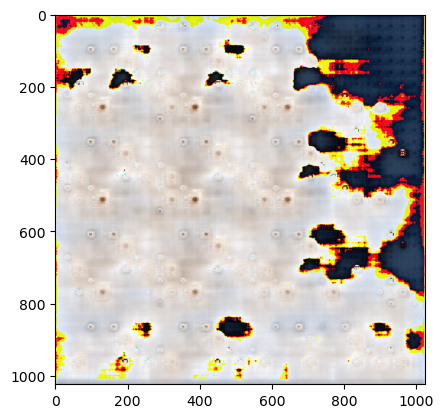

In [8]:
# Load the model
G_normal = Generator(3,3)
G_normal.load_state_dict(torch.load('G_art.pth'))
G_normal.eval()

# Load the image
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

img = Image.open('/kaggle/input/samplee2/6724351.webp')
img = transform(img).unsqueeze(0)

# Convert the image
with torch.no_grad():
    art_img = G_normal(img)

# Save the output
output = transforms.ToPILImage()(art_img.squeeze())
plt.imshow(output)
output.save('art_picture.jpg')
